### Baseline forecast for total daily consumption per household

Select n households from the total

Forecast total consumption for each household using daily totals as dataset

'datascience' virtualenv (tensorflow, sklearn pandas etc...)

In [ ]:
import sys
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
from math import sqrt

In [2]:
from numpy import split
from numpy import array
import numpy as np
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import pandas as pd
import dask
import dask.dataframe as dd
import seaborn as sns; sns.set()
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import ElasticNet, HuberRegressor, Lars
from sklearn.linear_model import LassoLars, PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor, SGDRegressor

sys.path.append("../scripts/")
from forecast_utils import split_dataset, evaluate_forecasts, summarize_scores, evaluate_model, av_scores


/home/walle/.virtualenvs/datascience/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
PATH = '../input/merged_data/'

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
#half hourly
DAILY_SAMPLE_RATE= 24*2

### Read in data

We are just picking one of the larger files at random here (8.9MB)

In [6]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

mac = pd.read_csv('{0}LCLid/mac000230.csv'.format(PATH), parse_dates=['day_time'], date_parser=dateparse)

In [7]:
mac.sort_values(by=['day_time'], inplace=True)

In [8]:
mac.head(n=2)

,LCLid,energy(kWh/hh),dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,dayIs_month_end,dayIs_month_start,dayIs_quarter_end,dayIs_quarter_start,dayIs_year_end,dayIs_year_start,dayElapsed,delta_minutes,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,humidity,summary,day_time,is_bank_holiday,Bank_holiday_Boxing_Day,Bank_holiday_Christmas_Day,Bank_holiday_Early_May_bank_holiday,Bank_holiday_Easter_Monday,Bank_holiday_Good_Friday,Bank_holiday_New_Years_Day,Bank_holiday_New_Years_Day_substitute_day,Bank_holiday_Queens_Diamond_Jubilee_extra_bank_holiday,Bank_holiday_Spring_bank_holiday,Bank_holiday_Spring_bank_holiday_substitute_day,Bank_holiday_Summer_bank_holiday,energy_csum
39164,MAC000230,NaN,2011,12,48,1,3,335,False,True,False,False,False,False,1322697600,-455040,7.890,178.0,9.44,8.110,1009.980,6.230,6.97,rain,0.910,Mostly Cloudy,2011-12-01 00:00:00,False,0,0,0,0,0,0,0,0,0,0,0,NaN
39165,MAC000230,NaN,2011,12,48,1,3,335,False,True,False,False,False,False,1322697600,-455010,9.375,182.5,9.91,8.625,1009.125,8.305,7.31,rain,0.915,Mostly Cloudy,2011-12-01 00:30:00,False,0,0,0,0,0,0,0,0,0,0,0,NaN


In [9]:
mac.tail(n=2)

,LCLid,energy(kWh/hh),dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,dayIs_month_end,dayIs_month_start,dayIs_quarter_end,dayIs_quarter_start,dayIs_year_end,dayIs_year_start,dayElapsed,delta_minutes,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,humidity,summary,day_time,is_bank_holiday,Bank_holiday_Boxing_Day,Bank_holiday_Christmas_Day,Bank_holiday_Early_May_bank_holiday,Bank_holiday_Easter_Monday,Bank_holiday_Good_Friday,Bank_holiday_New_Years_Day,Bank_holiday_New_Years_Day_substitute_day,Bank_holiday_Queens_Diamond_Jubilee_extra_bank_holiday,Bank_holiday_Spring_bank_holiday,Bank_holiday_Spring_bank_holiday_substitute_day,Bank_holiday_Summer_bank_holiday,energy_csum
24234,MAC000230,NaN,2014,2,9,28,4,59,True,False,False,False,False,False,1393545600,727140,7.130,333.0,5.170,3.43,1003.420,2.870,2.79,rain,0.89,Clear,2014-02-28 23:00:00,False,0,0,0,0,0,0,0,0,0,0,0,NaN
24235,MAC000230,NaN,2014,2,9,28,4,59,True,False,False,False,False,False,1393545600,727170,10.165,285.0,5.655,3.29,1002.305,3.345,2.93,rain,0.85,Clear,2014-02-28 23:30:00,False,0,0,0,0,0,0,0,0,0,0,0,NaN


In [10]:
mac.set_index(['day_time'],inplace=True)

In [11]:
#convert to time series:
ts_raw = mac['energy(kWh/hh)']

In [12]:
plt.rcParams["figure.figsize"] = (18,4)

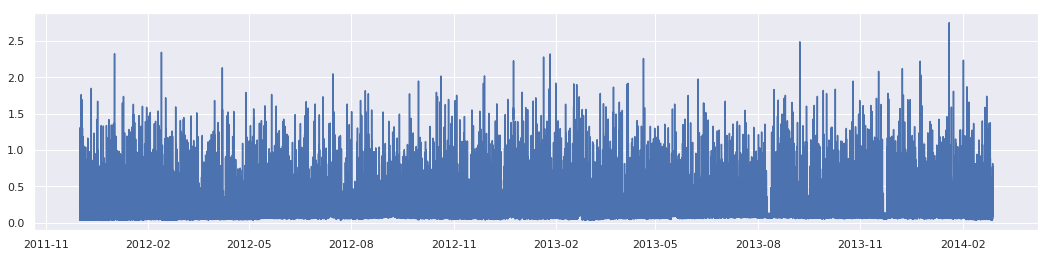

In [13]:
plt.plot(ts_raw)

In [14]:
mac['energy_csum'] = mac['energy(kWh/hh)'].cumsum()

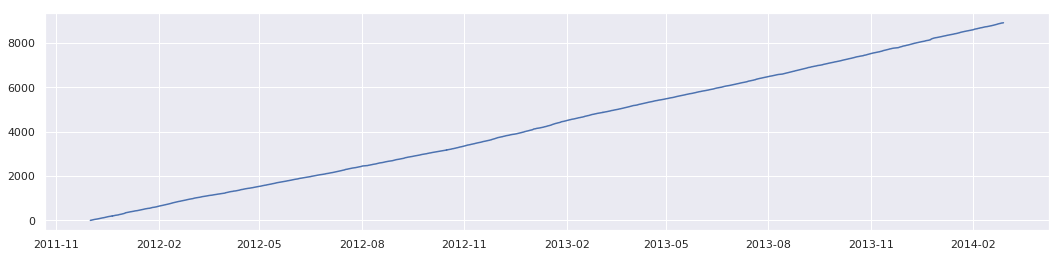

In [15]:
ts_csum = mac['energy_csum']
#plt.yscale('log')
plt.plot(ts_csum)

In [16]:
mac['energy_week_rolling'] = mac['energy(kWh/hh)'].rolling(window=2, win_type='hamming').mean()

In [17]:
#convert energy_week_rolling to time series:
ts = mac['energy_week_rolling']

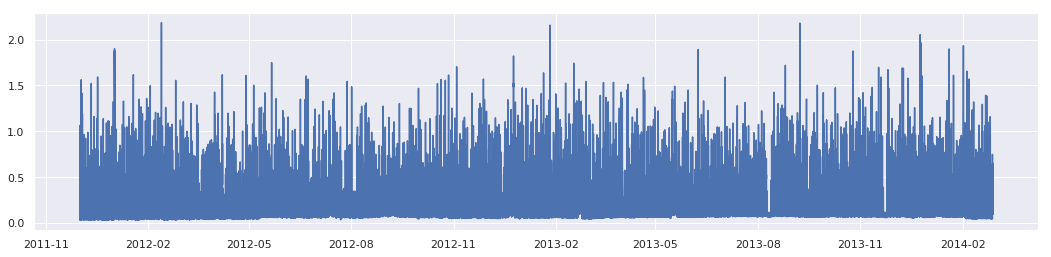

In [18]:
plt.plot(ts)

In [19]:
mac[500:505]

,LCLid,energy(kWh/hh),dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,dayIs_month_end,dayIs_month_start,dayIs_quarter_end,dayIs_quarter_start,dayIs_year_end,dayIs_year_start,dayElapsed,delta_minutes,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,humidity,summary,is_bank_holiday,Bank_holiday_Boxing_Day,Bank_holiday_Christmas_Day,Bank_holiday_Early_May_bank_holiday,Bank_holiday_Easter_Monday,Bank_holiday_Good_Friday,Bank_holiday_New_Years_Day,Bank_holiday_New_Years_Day_substitute_day,Bank_holiday_Queens_Diamond_Jubilee_extra_bank_holiday,Bank_holiday_Spring_bank_holiday,Bank_holiday_Spring_bank_holiday_substitute_day,Bank_holiday_Summer_bank_holiday,energy_csum,energy_week_rolling
day_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-12-11 10:00:00,MAC000230,0.049,2011,12,49,11,6,345,False,False,False,False,False,False,1323561600,-440040,12.540,195.0,7.050,5.44,1009.820,4.100,4.550,rain,0.900,Partly Cloudy,False,0,0,0,0,0,0,0,0,0,0,0,101.861,0.0430
2011-12-11 10:30:00,MAC000230,0.480,2011,12,49,11,6,345,False,False,False,False,False,False,1323561600,-440010,12.635,196.0,7.510,5.73,1009.475,4.525,4.890,rain,0.890,Partly Cloudy,False,0,0,0,0,0,0,0,0,0,0,0,102.341,0.2645
2011-12-11 11:00:00,MAC000230,0.226,2011,12,49,11,6,345,False,False,False,False,False,False,1323561600,-439980,12.730,197.0,7.970,6.02,1009.130,4.950,5.230,rain,0.880,Mostly Cloudy,False,0,0,0,0,0,0,0,0,0,0,0,102.567,0.3530
2011-12-11 11:30:00,MAC000230,0.234,2011,12,49,11,6,345,False,False,False,False,False,False,1323561600,-439950,12.215,197.0,8.015,6.03,1008.560,4.865,5.625,rain,0.875,Mostly Cloudy,False,0,0,0,0,0,0,0,0,0,0,0,102.801,0.2300
2011-12-11 12:00:00,MAC000230,0.158,2011,12,49,11,6,345,False,False,False,False,False,False,1323561600,-439920,11.700,197.0,8.060,6.04,1007.990,4.780,6.020,rain,0.870,Mostly Cloudy,False,0,0,0,0,0,0,0,0,0,0,0,102.959,0.1960


In [20]:
mac['energy_rolling_30'] = mac['energy(kWh/hh)'].rolling(window=30).mean()

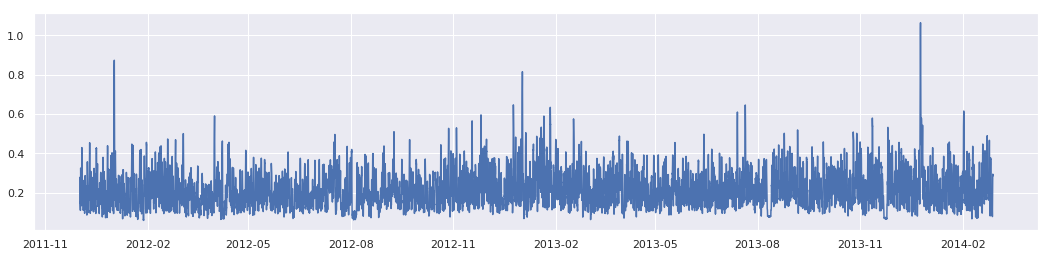

In [21]:
ts = mac['energy_rolling_30']
plt.plot(ts)

In [22]:
plt.close()

NB 2012 was a leap year

### Check dates

First check for any gaps in the half hourly data

In [23]:
#find the first valid value
mac['energy(kWh/hh)'].first_valid_index()

Timestamp('2011-12-01 11:00:00')

In [24]:
#find the last valid value
mac['energy(kWh/hh)'].last_valid_index()

Timestamp('2014-02-28 00:00:00')

Lets start on the first Sunday morning after first valid data

And end on Last Sunday morning before last valid point

In [25]:
#start at start of Sunday
start = datetime(2011,12,4)
#End at start of Sunday
end = datetime(2014,2,23)

In [26]:
delta = relativedelta(end, start)

In [27]:
delta

relativedelta(years=+2, months=+2, days=+19)

In [28]:
(end - start).days

812

In [29]:
# Clip the data to the required range
mac['day'] = mac.index
mask= (mac['day'] >= start) & (mac['day'] < end)
mac = mac.loc[mask]

Note date_range is inclusive of the end date

In [30]:
#Test date range will give us correct values for a single day
test_date_range = pd.date_range('2011-12-4 00:00:00', '2011-12-4 23:30:00', freq='30Min')
print(len(test_date_range)/48)
test_date_range[0], test_date_range[-1]

1.0


(Timestamp('2011-12-04 00:00:00', freq='30T'),
 Timestamp('2011-12-04 23:30:00', freq='30T'))

In [31]:
ref_date_range = pd.date_range('2011-12-4 00:00:00', '2014-2-22 23:30:00', freq='30Min')

In [32]:
ref_df = pd.DataFrame(np.random.randint(1, 20, (ref_date_range.shape[0], 1)))
ref_df.index = ref_date_range  # set index

In [33]:
#check for missing datetimeindex values based on reference index (with all values) 
missing_dates = ref_df.index[~ref_df.index.isin(mac.index)]

#print('frac missing: {0}'.format(len(missing_dates)/len(mac)))

In [34]:
len(missing_dates), len(mac), missing_dates

(4, 38972, DatetimeIndex(['2013-09-09 23:00:00', '2013-09-09 23:30:00',
                '2013-09-10 00:00:00', '2013-09-10 00:30:00'],
               dtype='datetime64[ns]', freq='30T'))

### Individual household associated

Add these back in - here we just use previous and following values - but could use null or average

TODO some columns need to be adjusted (eg sum)

TODO check if these are missing from the entire dataset

In [35]:
prev_row = mac.loc['2013-09-09 22:30:00']
post_row = mac.loc['2013-09-10 01:00:00']

As a quick hack we are just going to duplicate the prev row 2x and post row 2x to fill in the gaps

In [36]:
# DatetimeIndex.insert(loc, item)[source]
mac.loc[pd.to_datetime('2013-09-09 23:00:00')] = prev_row
mac.loc[pd.to_datetime('2013-09-09 23:30:00')] = prev_row
mac.loc[pd.to_datetime('2013-09-10 00:00:00')] = post_row
mac.loc[pd.to_datetime('2013-09-10 00:30:00')] = post_row

In [37]:
mac = mac.sort_index()

In [38]:
#double check missing dates were fixed
missing_dates = ref_df.index[~ref_df.index.isin(mac.index)]

print('frac missing: {0}, total: {1}, total days: {2}'.format(len(missing_dates)/len(mac), len(mac), len(mac)/48))

frac missing: 0.0, total: 38976, total days: 812.0


In [39]:
#check if more than necessary in data
inv_missing_dates = mac.index[~mac.index.isin(ref_df.index)]
print('frac missing: {0}, inv_missing_dates: {1}'.format(len(inv_missing_dates)/len(mac), inv_missing_dates))

frac missing: 0.0, inv_missing_dates: DatetimeIndex([], dtype='datetime64[ns]', name='day_time', freq=None)


In [40]:
len(ref_df), len(ref_df)/48, len(mac), len(mac)/48

(38976, 812.0, 38976, 812.0)

In [41]:
import calendar

In [42]:
calendar.day_name[mac['day'][0].weekday()]

'Sunday'

In [43]:
mac.head(n=2)

,LCLid,energy(kWh/hh),dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,dayIs_month_end,dayIs_month_start,dayIs_quarter_end,dayIs_quarter_start,dayIs_year_end,dayIs_year_start,dayElapsed,delta_minutes,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,humidity,summary,is_bank_holiday,Bank_holiday_Boxing_Day,Bank_holiday_Christmas_Day,Bank_holiday_Early_May_bank_holiday,Bank_holiday_Easter_Monday,Bank_holiday_Good_Friday,Bank_holiday_New_Years_Day,Bank_holiday_New_Years_Day_substitute_day,Bank_holiday_Queens_Diamond_Jubilee_extra_bank_holiday,Bank_holiday_Spring_bank_holiday,Bank_holiday_Spring_bank_holiday_substitute_day,Bank_holiday_Summer_bank_holiday,energy_csum,energy_week_rolling,energy_rolling_30,day
day_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-12-04 00:00:00,MAC000230,0.075,2011,12,48,4,6,338,False,False,False,False,False,False,1322956800,-450720,13.070,243.0,8.60,6.330,1003.92,6.130,4.310,rain,0.86,Mostly Cloudy,False,0,0,0,0,0,0,0,0,0,0,0,32.549,0.0690,0.427233,2011-12-04 00:00:00
2011-12-04 00:30:00,MAC000230,0.048,2011,12,48,4,6,338,False,False,False,False,False,False,1322956800,-450690,13.125,248.0,8.62,6.375,1003.81,6.185,4.255,rain,0.86,Mostly Cloudy,False,0,0,0,0,0,0,0,0,0,0,0,32.597,0.0615,0.420667,2011-12-04 00:30:00


In [44]:
mac.tail(n=1)

,LCLid,energy(kWh/hh),dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,dayIs_month_end,dayIs_month_start,dayIs_quarter_end,dayIs_quarter_start,dayIs_year_end,dayIs_year_start,dayElapsed,delta_minutes,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,humidity,summary,is_bank_holiday,Bank_holiday_Boxing_Day,Bank_holiday_Christmas_Day,Bank_holiday_Early_May_bank_holiday,Bank_holiday_Easter_Monday,Bank_holiday_Good_Friday,Bank_holiday_New_Years_Day,Bank_holiday_New_Years_Day_substitute_day,Bank_holiday_Queens_Diamond_Jubilee_extra_bank_holiday,Bank_holiday_Spring_bank_holiday,Bank_holiday_Spring_bank_holiday_substitute_day,Bank_holiday_Summer_bank_holiday,energy_csum,energy_week_rolling,energy_rolling_30,day
day_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-02-22 23:30:00,MAC000230,0.079,2014,2,8,22,5,53,False,False,False,False,False,False,1393027200,718530,13.195,225.5,5.905,2.21,1002.84,2.125,5.755,rain,0.77,Clear,False,0,0,0,0,0,0,0,0,0,0,0,8854.124,0.2955,0.488233,2014-02-22 23:30:00


Lets looks at weekly energy use

In [45]:
weeks = mac.groupby(pd.Grouper(freq='W', key='day'))['energy(kWh/hh)'].agg(['max','last', 'mean'])

In [46]:
weeks.tail()

,max,last,mean
day,,,
2014-01-26,1.807,0.284,0.224595
2014-02-02,2.234,0.126,0.247518
2014-02-09,1.868,0.092,0.231202
2014-02-16,1.364,0.066,0.201265
2014-02-23,1.738,0.079,0.281701


### Create Forecast

In [47]:
# daily persistence model
def daily_persistence(history):
    # get the data for the prior week
    #print('len(history): {0}'.format(len(history)))
    last_week = history[-1]
    # get the total value for the last day
    value = last_week[-1, 0]
    # prepare 7 day forecast
    forecast = [value for _ in range(7*DAILY_SAMPLE_RATE)]
    return forecast

In [48]:
# weekly persistence model
def weekly_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    return last_week[:, 0]

In [49]:
# week one year ago persistence model
def week_one_year_ago_persistence(history):
    # get the data for the prior week
    last_week = history[-52]
    return last_week[:, 0]

In [50]:
mac_df =  mac[['energy(kWh/hh)', 'temperature', 'humidity']]
mac_df=mac_df.fillna(0)


In [51]:
# split into train and test
train, test = split_dataset(mac_df.values, DAILY_SAMPLE_RATE)

train: 36288, split weeks: 108.0
test: 36288, split weeks: 108.0


In [52]:
# define the names and functions for the models we wish to evaluate
models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-one_year_ago'] = week_one_year_ago_persistence

<class 'list'>
daily: [0.291] 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3
<class 'list'>
weekly: [0.302] 0.2, 0.3, 0.3, 0.2, 0.3, 0.3, 0.3
<class 'list'>
week-one_year_ago: [0.310] 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3


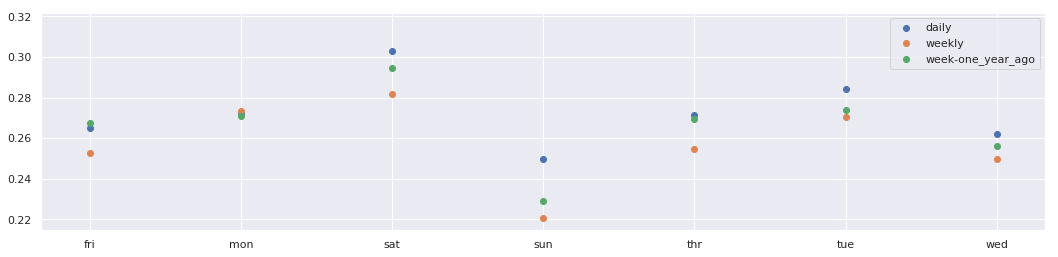

In [53]:
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
#pseododays = list(range(1,8))
for name, func in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
    # summarize scores
    summarize_scores(name, score, scores, DAILY_SAMPLE_RATE)
    # plot scores
    av = av_scores(scores, DAILY_SAMPLE_RATE)
    #sns.scatterplot(days, av, marker='o', label=name)
    plt.scatter(days, av, marker='o', label=name)
# show plot
plt.legend()
plt.show()

In [ ]:
### Save the cleaned dataset for other forecasting methods

In [69]:
mac.head()

,LCLid,energy(kWh/hh),dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,dayIs_month_end,dayIs_month_start,dayIs_quarter_end,dayIs_quarter_start,dayIs_year_end,dayIs_year_start,dayElapsed,delta_minutes,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,humidity,summary,is_bank_holiday,Bank_holiday_Boxing_Day,Bank_holiday_Christmas_Day,Bank_holiday_Early_May_bank_holiday,Bank_holiday_Easter_Monday,Bank_holiday_Good_Friday,Bank_holiday_New_Years_Day,Bank_holiday_New_Years_Day_substitute_day,Bank_holiday_Queens_Diamond_Jubilee_extra_bank_holiday,Bank_holiday_Spring_bank_holiday,Bank_holiday_Spring_bank_holiday_substitute_day,Bank_holiday_Summer_bank_holiday,energy_csum,energy_week_rolling,energy_rolling_30,day
day_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-12-04 00:00:00,MAC000230,0.075,2011,12,48,4,6,338,False,False,False,False,False,False,1322956800,-450720,13.070,243.0,8.600,6.330,1003.92,6.130,4.310,rain,0.86,Mostly Cloudy,False,0,0,0,0,0,0,0,0,0,0,0,32.549,0.0690,0.427233,2011-12-04 00:00:00
2011-12-04 00:30:00,MAC000230,0.048,2011,12,48,4,6,338,False,False,False,False,False,False,1322956800,-450690,13.125,248.0,8.620,6.375,1003.81,6.185,4.255,rain,0.86,Mostly Cloudy,False,0,0,0,0,0,0,0,0,0,0,0,32.597,0.0615,0.420667,2011-12-04 00:30:00
2011-12-04 01:00:00,MAC000230,0.056,2011,12,48,4,6,338,False,False,False,False,False,False,1322956800,-450660,13.180,253.0,8.640,6.420,1003.70,6.240,4.200,rain,0.86,Mostly Cloudy,False,0,0,0,0,0,0,0,0,0,0,0,32.653,0.0520,0.405100,2011-12-04 01:00:00
2011-12-04 01:30:00,MAC000230,0.040,2011,12,48,4,6,338,False,False,False,False,False,False,1322956800,-450630,13.315,252.5,8.635,6.410,1003.70,6.230,4.200,rain,0.86,Mostly Cloudy,False,0,0,0,0,0,0,0,0,0,0,0,32.693,0.0480,0.402467,2011-12-04 01:30:00
2011-12-04 02:00:00,MAC000230,0.058,2011,12,48,4,6,338,False,False,False,False,False,False,1322956800,-450600,13.450,252.0,8.630,6.400,1003.70,6.220,4.200,rain,0.86,Mostly Cloudy,False,0,0,0,0,0,0,0,0,0,0,0,32.751,0.0490,0.399600,2011-12-04 02:00:00


In [68]:
mac.to_csv('{0}LCLid/clean_mac000230.csv'.format(PATH))

In [70]:
len(mac)

38976

## Daily data

Daily data is far less noisy than half houly, lets compare prediction accuracy
